In [1]:
%matplotlib inline

import sys
sys.path.append('../python_packages_static')
import geopandas as gp
import flopy as fp
import mfsetup
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pyproj

## Using [modflow-setup](https://github.com/aleaf/modflow-setup/tree/develop/mfsetup) it is possible to build only the discretization package to evaluate grid options.

#### get base dir - need this because MODFLOW setup leaves us in the model directory

In [2]:
basedir = os.getcwd()
basedir

'C:\\Users\\dbabrams\\Documents\\ISWS\\GitHub\\neversink_workflow\\notebooks_preprocessing_blank'

## first get bounding box for the model domain

In [3]:
#domain = gp.read_file('../source_data/shapefiles/Extents/Model_Extent_HUC12.shp')

domain = gp.read_file('../source_data/shapefiles/Mahomet_model_shapefiles/mahomet.shp')

### get the CRS - we'll need this later on

US survey foot


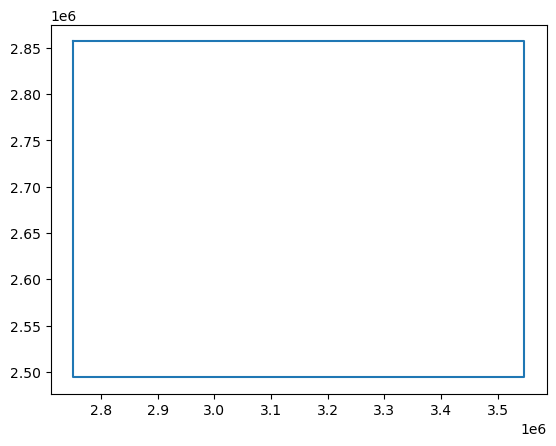

796959.9999403358 364000.0000484139


In [4]:
#epsg = pyproj.CRS(domain2.crs).to_epsg()
print(domain.crs.axis_info[0].unit_name)

#modflow output indicates meters... but shapefile still shows feet... something is screwy

#testing for eventual spyder porting
plt.plot(*domain.geometry[0].exterior.xy)
plt.show() #this is fine

bounds = domain.geometry[0].bounds

tot_xdist, tot_ydist = bounds[2]+1000-bounds[0], bounds[3]+1000-bounds[1]
print (tot_xdist,tot_ydist)

### set grid spacing and set up grid

In [5]:
dx = 1320 #feet
dy = dx

xcells = int(np.ceil(tot_xdist/dx))
ycells = int(np.ceil(tot_ydist/dy))

print(xcells,ycells, xcells*ycells)

604 276 166704


## Read in the file `example.yml`

In [6]:
#mf6_default.yml crs needs to be modified. See below

#crs: 'PROJCS["Clarke_1866_Lambert_Conformal_Conic",GEOGCS["NAD27",DATUM["North_American_Datum_1927",SPHEROID["Clarke 1866",6378206.4,294.9786982,AUTHORITY["EPSG","7008"]],AUTHORITY["EPSG","6267"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",33],PARAMETER["central_meridian",-89.5],PARAMETER["standard_parallel_1",33],PARAMETER["standard_parallel_2",45],PARAMETER["false_easting",2999994],PARAMETER["false_northing",0],UNIT["foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

with open('example_mahomet.yml', 'r') as ifp:
    inyml = yaml.load(ifp, Loader=yaml.FullLoader)
   
inyml['setup_grid']['xoff'] = bounds[0]
inyml['setup_grid']['yoff'] = bounds[1]

inyml['dis']['griddata']['delr'] = dy
inyml['dis']['griddata']['delc'] = dx

inyml['dis']['dimensions']['nlay'] = 1
inyml['dis']['dimensions']['nrow'] = ycells
inyml['dis']['dimensions']['ncol'] = xcells

with open('mahomet.yml', 'w') as ofp:
    yaml.dump(inyml, ofp)

### now try to make just the DIS package

In [7]:
m = mfsetup.MF6model.setup_from_yaml('mahomet.yml')

loading configuration file mahomet.yml...

Setting up mahomet model from data in None


validating configuration...
DIS package
done with validation.

setting up model grid...
wrote C:\Users\dbabrams\Documents\ISWS\GitHub\neversink_workflow\notebooks_preprocessing_blank\tmp\mahomet\mahomet_grid.json
writing C:\Users\dbabrams\Documents\ISWS\GitHub\neversink_workflow\notebooks_preprocessing_blank\tmp\mahomet\postproc\shps\mahomet_bbox.shp... Done
finished in 0.77s


Setting up TDIS package...
finished in 0.01s


Setting up IMS package...
finished in 0.00s


Setting up DIS package...
wrote .\external\top.dat, took 0.05s
loading original\mahomet_top.dat.original, shape=(276, 604), took 0.08s
computing cell thicknesses...
finished in 3.22s

wrote .\external\top.dat, took 0.04s
wrote .\external\botm_000.dat, took 0.03s
wrote .\external\top.dat, took 0.04s

reading C:\Users\dbabrams\Documents\ISWS\GitHub\neversink_workflow\source_data\shapefiles\Mahomet_model_shapefiles\mahomet.shp...
--> bui

In [8]:
m.dis.idomain.array.sum() * 5

829125

### We can export the grid information as a shapefile to evaluate
NOTE: Errors indicating "No internet connection or epsg code ..." can be safely disregarded as warnings. They are due to restrictive network security preventing access to spatialreference.org but do not impact behavior of these notebooks.

In [9]:
m.dis.export('mahomet{}f.dis.shp'.format(dx))

wrote mahomet1320f.dis.shp


In [10]:
os.chdir(basedir)
